In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf


import warnings
warnings.filterwarnings("ignore")

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding,Conv1D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import concatenate
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
import scipy.stats

In [ ]:
df2 = pd.read_csv("CovertCast_home_world_dataset.csv")
#df=df2[['TotalPackets',' totalPacketsOut',' meanPacketSizesIn',' meanPacketSizesOut',' variancePacketSizesIn',' variancePacketSizesOut',' meanPacketTimesIn',' meanPacketTimesOut',' variancePacketTimesIn',' variancePacketTimesOut']].copy()

#df3=pd.read_csv('deltashaper.csv')
#df4=df3[['TotalPackets',' totalPacketsOut',' meanPacketSizesIn',' meanPacketSizesOut',' minPacketSizeIn',' maxPacketSizeIn',' variancePacketSizesIn',' minPacketSizeOut',' maxPacketSizeOut',' variancePacketSizesOut',' meanPacketTimesIn',' meanPacketTimesOut']].copy()

#frames = [df, df4]
  
#df = pd.concat(frames)
df=df2.drop([' Class'],axis=1)
df

,TotalPackets,totalPacketsIn,totalPacketsOut,totalBytes,totalBytesIn,totalBytesOut,minPacketSize,maxPacketSize,meanPacketSizes,stdevPacketSizes,variancePacketSizes,kurtosisPacketSizes,skewPacketSizes,p10PacketSizes,p20PacketSizes,p30PacketSizes,p40PacketSizes,p50PacketSizes,p60PacketSizes,p70PacketSizes,p80PacketSizes,p90PacketSizes,minPacketSizeIn,maxPacketSizeIn,meanPacketSizesIn,stdevPacketSizesIn,variancePacketSizesIn,skewPacketSizesIn,kurtosisPacketSizesIn,p10PacketSizesIn,p20PacketSizesIn,p30PacketSizesIn,p40PacketSizesIn,p50PacketSizesIn,p60PacketSizesIn,p70PacketSizesIn,p80PacketSizesIn,p90PacketSizesIn,minPacketSizeOut,maxPacketSizeOut,...,p30PacketTimesOut,p40PacketTimesOut,p50PacketTimesOut,p60PacketTimesOut,p70PacketTimesOut,p80PacketTimesOut,p90PacketTimesOut,totalBursts,maxBurst,meanBurst,stdevBurst,varianceBurst,kurtosisBurst,skewBurst,p10Burst,p20Burst,p30Burst,p40Burst,p50Burst,p60Burst,p70Burst,p80Burst,p90Burst,maxBurstBytes,minBurstBytes,meanBurstBytes,medianBurstBytes,stdevBurstBytes,varianceBurstBytes,kurtosisBurstBytes,skewBurstBytes,p10BurstBytes,p20BurstBytes,p30BurstBytes,p40BurstBytes,p50BurstBytes,p60BurstBytes,p70BurstBytes,p80BurstBytes,p90BurstBytes
0,24456,16253,8203,18431015,17708776,722239,60,1392,753.639802,626.353924,392319.238143,-1.932874,-0.029785,81.0,81.0,81.0,122.0,758.0,1392.0,1392.0,1392.0,1392.0,60,1392,1089.569679,501.577716,251580.204906,-1.195099,-0.399312,120.0,407.0,1392.0,1392.0,1392.0,1392.0,1392.0,1392.0,1392.0,65,1392,...,0.000159,0.000178,0.000186,0.000205,0.000253,0.000311,0.000412,1278,19,4.694053,2.634396,6.940043,0.658454,0.896378,2.0,2.0,3.0,3.0,4.0,5.0,6.0,7.0,8.0,3108,146,412.679186,402.0,254.783296,64914.527751,17.445829,2.404147,162.0,162.0,243.0,298.0,402.0,486.0,567.0,648.0,729.0
1,20558,13651,6907,15695659,15065575,630084,60,1392,763.481808,629.928606,396810.049163,-1.943262,-0.059616,83.0,83.0,83.0,119.0,943.5,1392.0,1392.0,1392.0,1392.0,60,1392,1103.624277,500.422479,250422.657088,-1.278332,-0.221269,118.0,410.0,1392.0,1392.0,1392.0,1392.0,1392.0,1392.0,1392.0,65,1392,...,0.000121,0.000164,0.000183,0.000202,0.000248,0.000309,0.000407,1287,19,3.887335,2.102772,4.421650,4.433301,1.608891,2.0,2.0,2.0,3.0,3.0,4.0,5.0,6.0,7.0,3088,146,351.349650,329.0,230.606178,53179.209524,28.814569,3.601584,166.0,166.0,166.0,249.0,329.0,332.0,415.0,498.0,664.0
2,20689,13681,7008,15905342,15209246,696096,58,1392,768.782541,629.772738,396613.701225,-1.940290,-0.074992,83.0,83.0,83.0,126.0,1009.0,1392.0,1392.0,1392.0,1392.0,58,1392,1111.705723,494.845097,244871.670144,-1.318477,-0.109299,120.0,437.0,1392.0,1392.0,1392.0,1392.0,1392.0,1392.0,1392.0,66,1392,...,0.000134,0.000176,0.000186,0.000212,0.000266,0.000348,0.000439,1396,23,3.745702,2.166548,4.693929,8.329926,2.107589,2.0,2.0,2.0,3.0,3.0,4.0,4.0,5.0,7.0,26042,158,381.337393,249.0,881.110792,776356.227857,581.544666,22.417874,166.0,166.0,166.0,249.0,249.0,332.0,415.0,498.0,664.0
3,21008,13937,7071,16117491,15482538,634953,60,1392,767.207302,629.202696,395896.032188,-1.938576,-0.071090,83.0,83.0,85.0,121.0,971.0,1392.0,1392.0,1392.0,1392.0,60,1392,1110.894597,493.950144,243986.744792,-1.314479,-0.111610,119.0,460.4,1392.0,1392.0,1392.0,1392.0,1392.0,1392.0,1392.0,65,681,...,0.000151,0.000178,0.000187,0.000207,0.000268,0.000350,0.000443,1260,21,4.312698,2.434670,5.927617,2.753959,1.325944,2.0,2.0,2.0,3.0,4.0,4.0,5.0,6.0,8.0,2413,158,390.982540,332.0,239.514184,57367.044140,6.163437,1.743245,166.0,166.0,247.0,249.0,332.0,415.0,498.0,581.0,711.4
4,22503,14939,7564,17183891,16507885,676006,60,1392,763.626672,627.503838,393761.066732,-1.936104,-0.058001,83.0,83.0,83.0,127.0,882.0,1392.0,1392.0,1392.0,1392.0,60,1392,1105.019412,494.600949,244630.098559,-1.273725,-0.211376,124.0,424.6,1392.0,1392.0,1392.0,1392.0,1392.0,1392.0,1392.0,67,795,...,0.000155,0.000179,0.000188,0.000216,0.000273,0.000352,0.000439,1353,14,4.271988,2.233903,4.990324,0.947665,0.989548,2.0,2.0,2.0,3.0,4.0,5.0,5.0,6.0,7.0,1485,158,377.609756,332.0,203.921738,41584

In [ ]:
mms = MinMaxScaler()
numerical_data_rescaled = mms.fit_transform(df)
numerical_data_rescaled
numerical_data_rescaled.shape[1]

135

In [ ]:
def build_generator(n_columns, latent_dim):
    model = Sequential()
    
    model.add(Dense(16, kernel_initializer = "he_uniform",input_dim=latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(32,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(64,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(128,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(256,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(256,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    
    #model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(n_columns, activation = "sigmoid"))
    return model

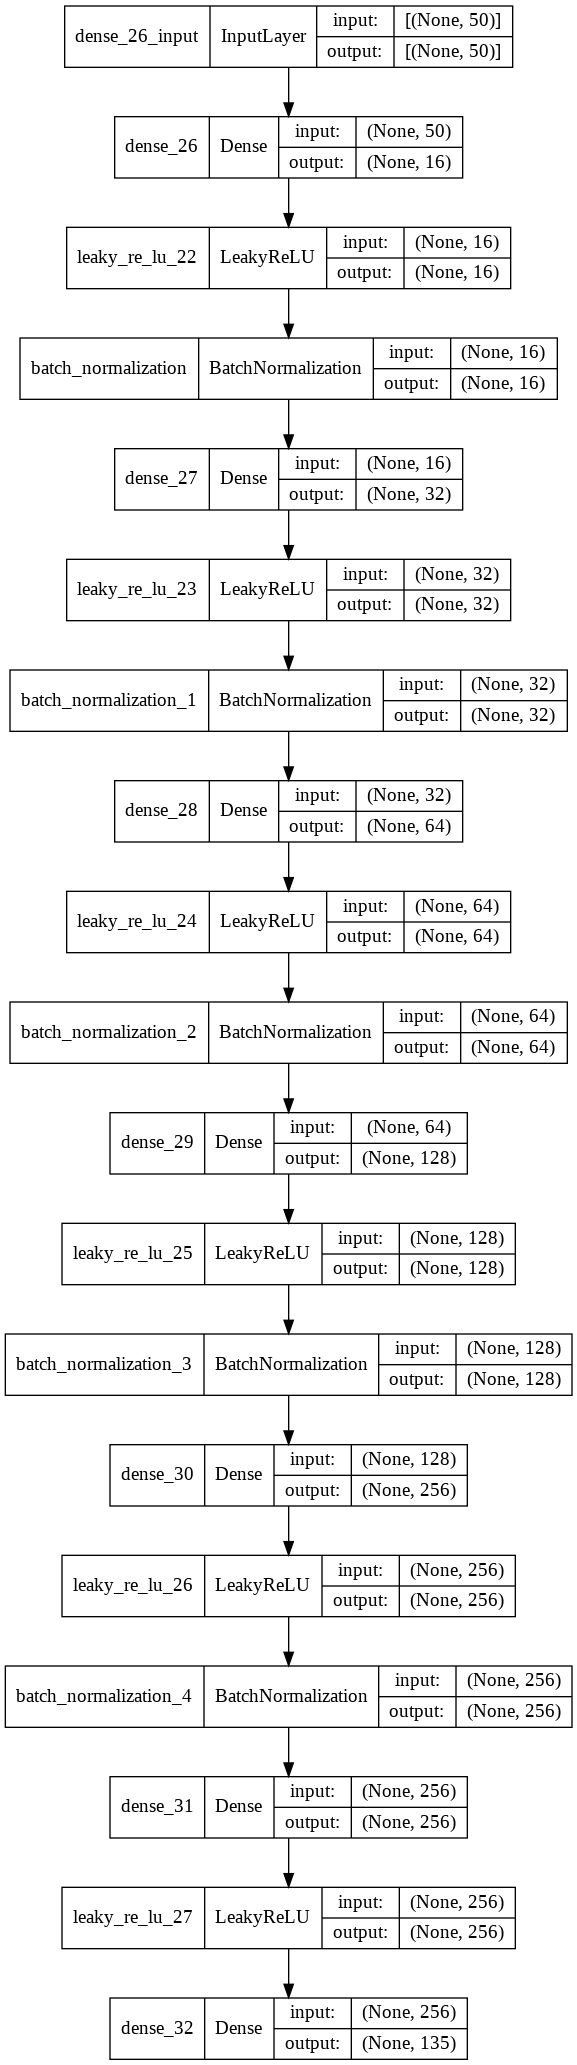

In [ ]:
latent_dim = 50
generator = build_generator(numerical_data_rescaled.shape[1], latent_dim)
plot_model(generator, show_layer_names = True, show_shapes = True)

In [ ]:
optimizer = Adam(lr=0.0002, beta_1=0.5)

In [ ]:
def build_discriminator(inputs_n):
	model = Sequential()

	model.add(Dense(256,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dropout(0.25))
	model.add(Dense(128,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dropout(0.25))
	model.add(Dense(64,  kernel_initializer = "he_uniform"))

	model.add(LeakyReLU(0.2))
	#model.add(BatchNormalization(momentum=0.8))
	model.add(Dropout(0.25))
	model.add(Dense(32,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	#model.add(BatchNormalization(momentum=0.8))
	model.add(Dropout(0.25))
	model.add(Dense(16,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	#model.add(BatchNormalization(momentum=0.8))
	model.add(Dropout(0.25))
	model.add(Dense(1, activation = "sigmoid"))
	model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
	return model

In [ ]:

discriminator = build_discriminator(numerical_data_rescaled.shape[1])
#plot_model(discriminator, show_layer_names = True, show_shapes = True)

In [ ]:
def build_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect generator and dicriminator
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss = "binary_crossentropy", optimizer = optimizer)
	return model

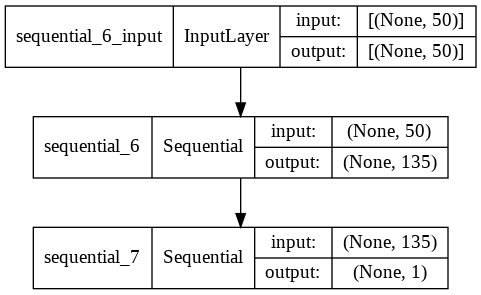

In [ ]:
gan = build_gan(generator, discriminator)
plot_model(gan, show_layer_names = True, show_shapes = True)

In [ ]:
def train(gan, generator, discriminator, data, latent_dim, n_epochs, n_batch, n_eval):
    #Half batch size for updateting discriminator
    half_batch = int(n_batch / 2)

    #lists for stats from the model
    generator_loss = []
    discriminator_loss = []

    #generate class labels for fake = 0 and real = 1
    valid = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    y_gan = np.ones((n_batch, 1))
    #training loop
    for i in range(n_epochs):
        
        #select random batch from the real numerical data
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_data = data[idx]
        
        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)
        

        #train the discriminator and return losses
        d_loss_real, _ = discriminator.train_on_batch(real_data, valid)
        d_loss_fake, _ = discriminator.train_on_batch(fake_data, fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator_loss.append(d_loss)
        

        #generate noise for generator input and  train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))
        g_loss = gan.train_on_batch(noise, y_gan)
        generator_loss.append(g_loss)

        #evaluate progress
        if (i+1) % n_eval == 0:
            print ("Epoch: %d [Generator loss: %f] [Discriminator loss: %f]" % (i + 1, g_loss, d_loss))

    #plot losses after training
    plt.figure(figsize = (20, 10))
    plt.plot(generator_loss, label = "Generator loss")
    plt.plot(discriminator_loss, label = "Discriminator loss")
    plt.title("Stats from training GAN")
    plt.legend()
    plt.grid()

Epoch: 250 [Generator loss: 0.708264] [Discriminator loss: 0.695248]
Epoch: 500 [Generator loss: 0.703048] [Discriminator loss: 0.695256]
Epoch: 750 [Generator loss: 0.710058] [Discriminator loss: 0.701878]
Epoch: 1000 [Generator loss: 0.696186] [Discriminator loss: 0.698468]
Epoch: 1250 [Generator loss: 0.698991] [Discriminator loss: 0.695457]
Epoch: 1500 [Generator loss: 0.701782] [Discriminator loss: 0.695415]
Epoch: 1750 [Generator loss: 0.695829] [Discriminator loss: 0.690766]
Epoch: 2000 [Generator loss: 0.696217] [Discriminator loss: 0.691451]
Epoch: 2250 [Generator loss: 0.700407] [Discriminator loss: 0.690784]
Epoch: 2500 [Generator loss: 0.703223] [Discriminator loss: 0.691396]
Epoch: 2750 [Generator loss: 0.702016] [Discriminator loss: 0.694391]
Epoch: 3000 [Generator loss: 0.702568] [Discriminator loss: 0.687945]
Epoch: 3250 [Generator loss: 0.704848] [Discriminator loss: 0.690730]
Epoch: 3500 [Generator loss: 0.706158] [Discriminator loss: 0.690059]
Epoch: 3750 [Generator 

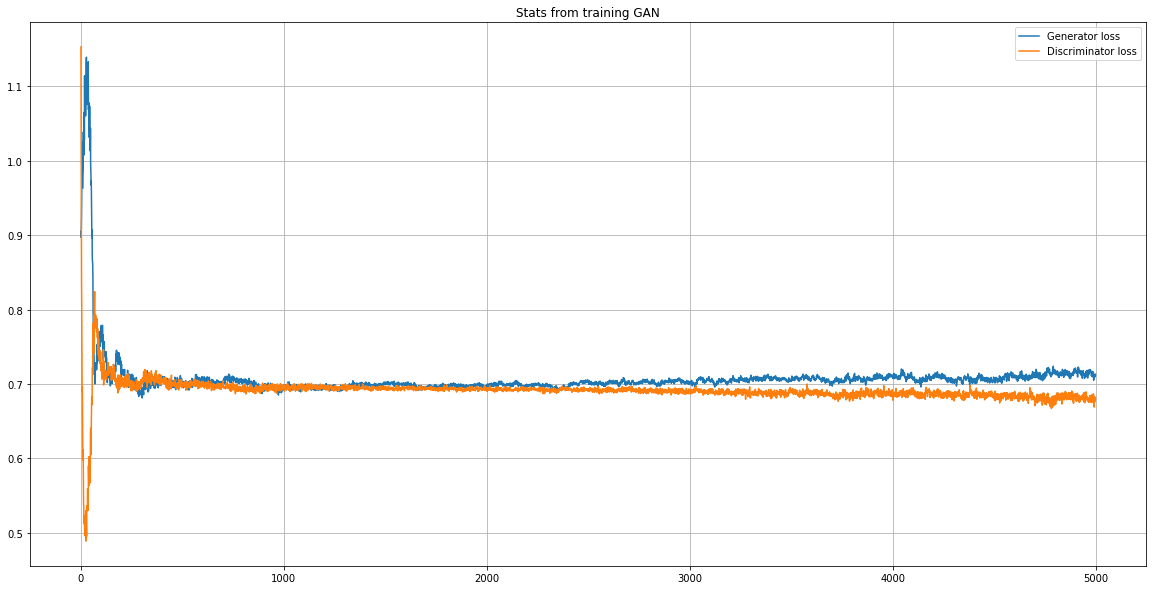

In [ ]:
train(gan, generator, discriminator, numerical_data_rescaled, latent_dim, n_epochs = 5000, n_batch = 1024, n_eval = 250)

In [ ]:
noise = np.random.normal(0, 1, (200, latent_dim))
generated_numerical_data = generator.predict(noise)
generated_numerical_data

array([[0.38949296, 0.45418304, 0.33664948, ..., 0.53219795, 0.816555  ,
        0.34361207],
       [0.1801526 , 0.25011754, 0.20169628, ..., 0.58984643, 0.7428513 ,
        0.13322648],
       [0.36145693, 0.37597832, 0.3097783 , ..., 0.14746845, 0.20300484,
        0.153959  ],
       ...,
       [0.3136412 , 0.40541318, 0.25014246, ..., 0.03188738, 0.18556973,
        0.22254601],
       [0.15130699, 0.34764045, 0.1426071 , ..., 0.81534344, 0.9020349 ,
        0.41845596],
       [0.09726369, 0.09197029, 0.13575292, ..., 0.53454375, 0.8698461 ,
        0.2415939 ]], dtype=float32)

In [ ]:
generated_numerical_data = mms.inverse_transform(generated_numerical_data)
gen_df = pd.DataFrame(data = generated_numerical_data, columns = df.columns)
gen_df

,TotalPackets,totalPacketsIn,totalPacketsOut,totalBytes,totalBytesIn,totalBytesOut,minPacketSize,maxPacketSize,meanPacketSizes,stdevPacketSizes,variancePacketSizes,kurtosisPacketSizes,skewPacketSizes,p10PacketSizes,p20PacketSizes,p30PacketSizes,p40PacketSizes,p50PacketSizes,p60PacketSizes,p70PacketSizes,p80PacketSizes,p90PacketSizes,minPacketSizeIn,maxPacketSizeIn,meanPacketSizesIn,stdevPacketSizesIn,variancePacketSizesIn,skewPacketSizesIn,kurtosisPacketSizesIn,p10PacketSizesIn,p20PacketSizesIn,p30PacketSizesIn,p40PacketSizesIn,p50PacketSizesIn,p60PacketSizesIn,p70PacketSizesIn,p80PacketSizesIn,p90PacketSizesIn,minPacketSizeOut,maxPacketSizeOut,...,p30PacketTimesOut,p40PacketTimesOut,p50PacketTimesOut,p60PacketTimesOut,p70PacketTimesOut,p80PacketTimesOut,p90PacketTimesOut,totalBursts,maxBurst,meanBurst,stdevBurst,varianceBurst,kurtosisBurst,skewBurst,p10Burst,p20Burst,p30Burst,p40Burst,p50Burst,p60Burst,p70Burst,p80Burst,p90Burst,maxBurstBytes,minBurstBytes,meanBurstBytes,medianBurstBytes,stdevBurstBytes,varianceBurstBytes,kurtosisBurstBytes,skewBurstBytes,p10BurstBytes,p20BurstBytes,p30BurstBytes,p40BurstBytes,p50BurstBytes,p60BurstBytes,p70BurstBytes,p80BurstBytes,p90BurstBytes
0,22525.798828,15394.435547,7484.485352,16720723.0,17026616.0,746561.6875,59.999985,1392.000244,773.180176,626.680847,389292.06250,-1.939172,-0.044432,82.998726,82.999168,82.623360,120.105652,1099.902954,1392.000122,1392.000000,1392.000122,1392.000244,59.999996,1392.000122,1133.665405,495.143433,244687.750000,-1.393357,-0.032313,149.004669,559.448608,1387.123291,1392.000122,1392.000244,1392.000366,1392.000000,1392.000366,1392.000366,66.998177,672.494629,...,0.000180,0.000185,0.000200,0.000242,0.000289,0.000352,0.000432,1282.313721,24.105755,4.375566,2.337137,5.616667,8.851619,1.547169,2.000153,2.000263,2.018755,2.999990,3.918649,4.371714,4.554379,5.125870,7.395358,1772.850952,160.646423,357.600952,371.258667,195.812164,21579.650391,1.054892,1.071638,165.999832,165.999878,248.857986,266.755615,365.132050,334.667755,425.689728,590.156677,723.717773
1,18995.273438,13233.995117,6637.249512,17636784.0,17075194.0,596106.6875,59.175346,1392.000244,761.941284,629.350098,394407.78125,-1.930104,-0.178379,82.998474,82.996277,83.446411,116.730225,943.017334,1392.000244,1392.000122,1392.000122,1392.000610,59.020317,1392.002197,1125.333374,513.124817,247049.406250,-1.165556,0.601633,116.987946,381.674255,1391.470459,1392.000000,1392.000610,1392.000488,1392.000366,1392.000122,1392.000122,66.999977,1378.114990,...,0.000171,0.000181,0.000202,0.000239,0.000295,0.000365,0.000448,1254.504517,22.494223,4.390409,2.368041,6.734534,6.206797,1.724768,2.000101,2.000121,2.001458,2.999917,3.849446,4.547365,4.762371,5.717810,7.089635,17833.152344,155.839249,425.710266,342.128845,399.748108,29479.898438,72.751831,5.643813,165.999557,165.999756,241.596191,318.557556,300.061920,398.228180,444.829010,559.363281,483.878174
2,22052.972656,14566.482422,7315.788086,16331994.0,16814868.0,671538.3750,59.998119,1392.000244,761.649963,628.111267,399583.18750,-1.938485,-0.099663,82.999458,82.999336,83.015205,112.591194,1090.023071,1392.000732,1392.000244,1392.000244,1392.001099,59.998421,1392.000366,1091.076782,460.953613,231442.093750,-1.441220,0.261021,132.980225,676.095093,1391.269409,1392.000244,1392.000244,1392.000366,1392.000366,1392.000244,1392.000122,66.970406,1357.673218,...,0.000171,0.000185,0.000213,0.000246,0.000304,0.000369,0.000426,1718.099365,16.552858,3.156614,1.554019,3.477680,11.086690,2.215023,2.000227,2.000458,2.000001,2.035828,2.575900,2.877398,3.148386,4.346371,5.121286,9639.452148,157.999161,258.346832,186.279907,399.894196,25885.998047,205.854599,12.727685,165.999588,165.998657,162.036850,177.625641,199.644287,215.887634,297.959534,333.815399,507.513245
3,21433.642578,12862.268555,7207.026367,15339267.0,15022524.0,634607.6875,60.000000,1392.000000,739.367737,631.533997,393481.68750,-1.944571,-0.017698,82.998596,82.135948,82.533180,111.913162,538.245422,1392.000000,1392

In [ ]:
gen_df=gen_df.astype(int)
gen_df.head()

,TotalPackets,totalPacketsIn,totalPacketsOut,totalBytes,totalBytesIn,totalBytesOut,minPacketSize
0,10102,6561,3493,8993740,8735093,359293,57
1,17133,11359,5861,15377151,14642659,565332,58
2,10942,7172,3731,9881383,9426099,385094,58
3,3675,2421,1341,3122016,3077808,167495,59
4,16298,10810,5539,14859586,14381252,530469,57


In [ ]:
gen_df.to_csv('fullvgan3_covertcast_dataset.csv')